In [0]:
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
!pip install scikit-learn
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
import urllib.request

print('Beginning file download...')

url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'

urllib.request.urlretrieve(url, './traffic-signs-data.zip')

Beginning file download...


('./traffic-signs-data.zip', <http.client.HTTPMessage at 0x7f04426d7240>)

In [0]:
import zipfile
import os


print('Beginning file unzip')

zip_ref = zipfile.ZipFile('./traffic-signs-data.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

print('Done')
os.listdir("./")

Beginning file unzip
Done


['.config',
 'traffic-signs-data.zip',
 'valid.p',
 'train.p',
 'test.p',
 'sample_data']

In [0]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
validation_file= './valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
print(y_train)

[41 41 41 ... 25 25 25]


In [0]:
import numpy as np
import pandas as pd

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [0]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    
    n_images = len(images)
    
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    
    fig = plt.figure(figsize=(2, 2))
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.grid(False)
        a.axis('off')
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, cmap='gray')
        a.set_title(title)
    
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def select_random_images_by_classes(features, labels, n_features):
  
  indexes = []
  _classes = np.unique(labels);
  
  while len(indexes) < len(_classes):
  
    index = random.randint(0, n_features-1)
    _class = labels[index]

    for i in range(0, len(_classes)):

      if _class == _classes[i]:
        _classes[i] = -1
        indexes.append(index)
        break

  images = []
  titles = []

  for i in range(0, len(indexes)):
    images.append(features[indexes[i]])
    titles.append("class " + str(labels[indexes[i]]))

  show_images(images, titles = titles)
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

#select_random_images_by_classes(X_train, y_train, n_train)

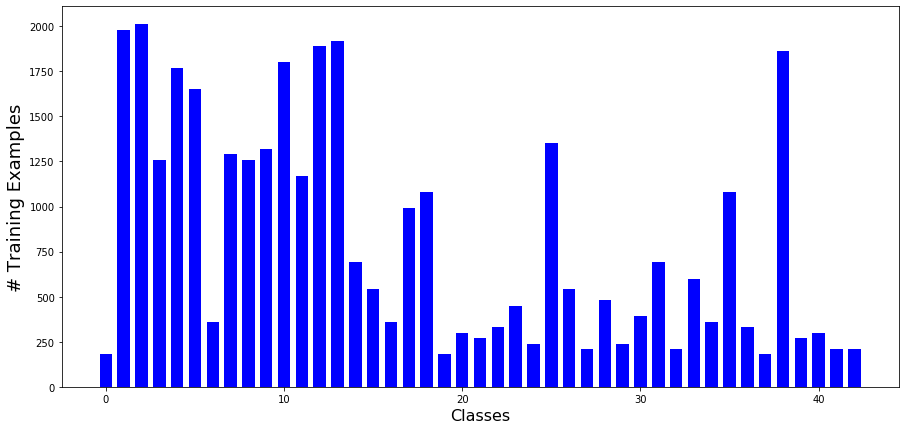

In [0]:
def plot_distribution_chart(x, y, xlabel, ylabel, width, color):
  
  plt.figure(figsize=(15,7))
  plt.ylabel(ylabel, fontsize=18)
  plt.xlabel(xlabel, fontsize=16)
  plt.bar(x, y, width, color=color)
  plt.show()
_classes, counts = np.unique(y_train, return_counts=True)

plot_distribution_chart(_classes, counts, 'Classes', '# Training Examples', 0.7, 'blue')

In [0]:
print('Transforming Images')
import cv2

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

Transforming Images


In [0]:
print('Adding Images')
images = []

for i in range(0, 100):
  images.append(transform_image(X_train[555],10,5,5,brightness=1))

#show_images(images)

Adding Images


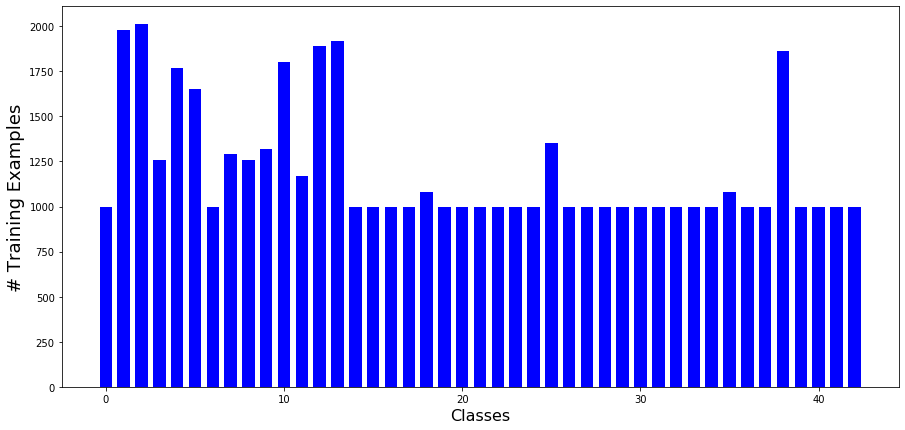

In [0]:
for _class, count in zip(_classes, counts):
  new_images = []
  new_classes = []
  
  if count < 1000:
    y_train_length = y_train.shape[0]
    index = 0
    
    for i in range(0, 1000-count):
      while y_train[index] != _class:
        index = random.randint(0, y_train_length-1)
      new_images.append(transform_image(X_train[index],10,5,5,brightness=1))
      new_classes.append(_class)
      
    X_train = np.concatenate((X_train, np.array(new_images)))
    y_train = np.concatenate((y_train, np.array(new_classes)))
    
_classes, counts = np.unique(y_train, return_counts=True)

plot_distribution_chart(_classes, counts, 'Classes', '# Training Examples', 0.7, 'blue')

In [0]:
#check dimentions

n_train = X_train.shape[0]

print("Number of training examples =", n_train)

Number of training examples = 51690


In [0]:
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)

X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)

X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)

# check grayscale images
#select_random_images_by_classes(X_train_gray.squeeze(), y_train, n_train)

In [0]:
print('Gray and Normalization')
X_train_gray -= np.mean(X_train_gray)

X_test_gray -= np.mean(X_test_gray)

X_train = X_train_gray

X_test = X_test_gray

Gray and Normalization


In [0]:

print('Splitting Data')
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=43)
X_train, y_train = shuffle(X_train, y_train)

Splitting Data


In [0]:
print("Testing Data :",X_test.shape[0])
X_test, y_test = shuffle(X_test, y_test)


Testing Data : 12630


In [0]:
print(X_test.shape)

(12630, 32, 32, 1)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
testcases = 10000
#print(a)
f= open("testcase_store_1.dat","w+")
for image in range(0,testcases):
  temp = X_test[image]
  temp2 = temp.flatten()
  a = list(temp2)
  #print(a.shape)
  for item in range(0,1024):
    if(item == 1023):
      f.write("%s" % temp2[item])
    else:
      f.write("%s," % temp2[item])
  f.write("\n")
f.close()
#    for item in a:
     #   f.write("%s," % item)

In [0]:
!rm -rf train_data
#select_random_images_by_classes(X_train_gray.squeeze(), y_train, n_train)
#plt.imshow(X_train[100])
#from keras.preprocessing.image import save_img
#!mkdir train_data
f= open("test_data_labels_1.txt","w+")
print(X_train.shape)
for i in range(testcases):
  #temp = X_train[i]
  #print(temp.shape)
  #plt.imshow(temp.squeeze(), cmap='gray')
  #plt.plot(X_train[100])
  #pic_name = './train_data/train_' + str(i) + '.bmp'
  #print(pic_name)
  f.write("%d\n" % (y_test[i]))
  #save_img(pic_name, temp)
f.close()


(41352, 32, 32, 1)


In [0]:
!mkdir ./drive/temp
!cp testcase_store_1.dat ./drive/MyDrive/ColabNotebooks/

mkdir: cannot create directory ‘./drive/temp’: Operation not supported
cp: cannot create regular file './drive/MyDrive/ColabNotebooks/': No such file or directory


In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(51690, 32, 32, 1)
(12630, 32, 32, 1)
(51690,)
(12630,)


In [0]:
print('Creating Model')
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='linear',padding='same', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(5, 5),padding='same', activation='linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Permute((2,3,1),input_shape=(1,8,8,16)))

model.add(Flatten(data_format='channels_first'))

model.add(Dense(120, activation='relu'))

model.add(Dense(84, activation='relu'))

model.add(Dense(43, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
#model.compile(optimizer='adam')


print(model.summary())

Creating Model


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
permute_1 (Permute)          (None, 8, 16, 8)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1

# Truncated model

In [0]:
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Permute

In [0]:
layer1 = Input(shape=(32, 32, 1))
layer2 = Conv2D(filters=6, kernel_size=(5, 5), activation='linear',padding='same')(layer1)
layer3 = MaxPooling2D(pool_size=(2, 2))(layer2)
layer4 = Conv2D(filters=16, kernel_size=(5, 5),padding='same', activation='linear')(layer3)
layer5 = MaxPooling2D(pool_size=(2, 2))(layer4)
layer6 = Permute((2,3,1),input_shape=(1,8,8,16))(layer5)
layer7 = Flatten(data_format='channels_first')(layer6)
layer8 = Dense(120, activation='relu')(layer7)
layer9 = Dense(84, activation='relu')(layer8)
layer10 = Dense(43, activation='linear')(layer9)


modelTrun = Model(inputs=layer1, outputs=layer10)


In [0]:
model.layers

In [0]:
modelTrun.layers

In [0]:
modelTrun.layers[1].set_weights(model.layers[0].get_weights())
print(modelTrun.layers[1].name)
modelTrun.layers[3].set_weights(model.layers[2].get_weights())
print(model.layers[2].get_weights()[0].shape)
modelTrun.layers[7].set_weights(model.layers[6].get_weights())
print(model.layers[2].get_weights()[0].shape)
print(model.layers[6].get_weights()[0])
modelTrun.layers[8].set_weights(model.layers[7].get_weights())
modelTrun.layers[9].set_weights(model.layers[8].get_weights())
#modelTrun.layers[7].set_weights(model.layers[6].get_weights())

conv2d_5
(5, 5, 6, 16)
(5, 5, 6, 16)
[[-0.14103477 -0.07945833  0.07903114 ... -0.03538329  0.08553936
   0.06251408]
 [-0.11834379  0.0634866  -0.09428247 ... -0.15669985  0.11385366
   0.01598304]
 [-0.31916317  0.05278066  0.01926571 ... -0.05583644 -0.06153942
   0.14986664]
 ...
 [ 0.05827881  0.02297347 -0.02531936 ...  0.12118549 -0.16320783
  -0.01260053]
 [ 0.15813996  0.1672386  -0.15332513 ...  0.02608208 -0.06332481
  -0.07198568]
 [ 0.03352179  0.05238286 -0.04615364 ... -0.08448441 -0.16451675
  -0.1321463 ]]


In [0]:
print(X_train[0])
print(y_train[0])

In [0]:
testImg = []
with open("data_1.txt", "r") as handle:
  pixels = handle.readline().split(",")

In [0]:
pixels[-1] = pixels[-1].replace("\n", '')

In [0]:
for pixel in pixels:
  testImg.append(float(pixel))
testImg = np.array(testImg)

In [0]:
testImg = testImg.reshape(32, 32)

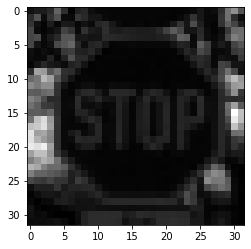

In [0]:
plt.imshow(testImg, cmap='gray')

In [0]:
testImg = X_train[0]
print(testImg.shape)
print(testImg)

In [0]:
print(X_test.shape)

(12630, 32, 32, 1)


In [0]:
import evaluate

ModuleNotFoundError: ignored

In [0]:
print(y_test.shape)

(12630,)


In [0]:
out.shape

(12630, 43)

In [0]:
out = model.predict(X_test.reshape(12630, 32, 32, 1))
out_class = out.argmax(axis=1)
accuracy_score(out_class, y_test) * 100.0

86.89627870150436

In [0]:
out.shape

(12630, 43)

In [0]:
print(out.size)
#print(out[0,:,:,0])
print(out[0,:])

543090
[ 95.60576    -4.622025   49.610218  -67.99673    -8.345063   85.098335
 -65.03355   -28.798613  -29.39731   -54.199604    1.3541579   2.969069
 -41.606194  -61.280655  -43.33508    22.187256  -21.63796   -10.643746
  20.37904    49.753025  -23.840181   38.64134   -48.66615    39.4068
 -15.624521  -13.574421    2.069559   14.507289   -8.654665  -12.195918
   8.3329315 -65.99908    23.401691   16.013332  -46.708538   -8.389781
 -45.883812   40.020336   19.476461   10.551849   28.521679   35.05598
  11.417079 ]


OLD


In [0]:
print(out.size)
print(out.shape)
print(out[0,:,:,0])
#print(out[0,:])

1024
(1, 8, 8, 16)
[[ 1.9224397   4.1990595   1.8997525   4.2643905  -1.341603    0.7132209
   1.9247137  -0.46587673]
 [-1.3509785  -1.5505345   2.291257    3.903523    2.5900006  -1.3122301
  -0.04468393 -0.4912632 ]
 [ 1.4164307  -0.30430073 -0.18047419  2.5431838   1.646069   -2.7801437
  -0.8458667   0.36696297]
 [ 0.1630539   0.5661162   0.1270679   1.7684673  -2.9293075  -1.0212553
  -0.56190085 -0.2979328 ]
 [-0.7139307  -0.44681835 -2.251574   -0.9521045  -1.1147404   1.6351727
   0.0642783  -1.2616436 ]
 [-0.69095117  3.0771933   4.553533   -1.326423    1.4464163  -1.3532064
  -1.9677309  -0.11469842]
 [ 4.0096283   3.8382182  -0.12225203  3.6305566   4.573894    2.9741945
   3.7714367   0.32088977]
 [ 4.2992163  -2.0331347  -2.0156636  -0.18745214 -1.7043794  -2.1267974
   1.023252   -0.6975614 ]]


In [0]:
print(len(X_train))
print(X_train.shape)
print(y_train.shape)
y_train_labels = y_train

from keras.utils import to_categorical
y_train_labels = to_categorical(y_train_labels)
print(y_train_labels.shape)

y_validation_labels = y_validation
from keras.utils import to_categorical
y_validation_labels = to_categorical(y_validation_labels)
print(y_validation_labels.shape)


41352
(41352, 32, 32, 1)
(41352,)
(41352, 43)
(10338, 43)


In [0]:
history = model.fit(X_train, y_train_labels, epochs=10, validation_data=(X_validation, y_validation_labels))

41352/41352 [==============================] - 18s 425us/step - loss: 1.4089 - acc: 0.6649 - val_loss: 0.4620 - val_acc: 0.8750
Epoch 2/10
41352/41352 [==============================] - 11s 259us/step - loss: 0.3139 - acc: 0.9151 - val_loss: 0.4177 - val_acc: 0.8929
Epoch 3/10
41352/41352 [==============================] - 11s 260us/step - loss: 0.2186 - acc: 0.9425 - val_loss: 0.2434 - val_acc: 0.9381
Epoch 4/10
41352/41352 [==============================] - 11s 259us/step - loss: 0.1784 - acc: 0.9529 - val_loss: 0.2717 - val_acc: 0.9460
Epoch 5/10
41352/41352 [==============================] - 11s 260us/step - loss: 0.1549 - acc: 0.9612 - val_loss: 0.2750 - val_acc: 0.9424
Epoch 6/10
41352/41352 [==============================] - 11s 259us/step - loss: 0.1469 - acc: 0.9650 - val_loss: 0.2867 - val_acc: 0.9420
Epoch 7/10
41352/41352 [==============================] - 11s 259us/step - loss: 0.1272 - acc: 0.9690 - val_loss: 0.5551 - val_acc: 0.9089
Epoch 8/10
41352/41352 [==============

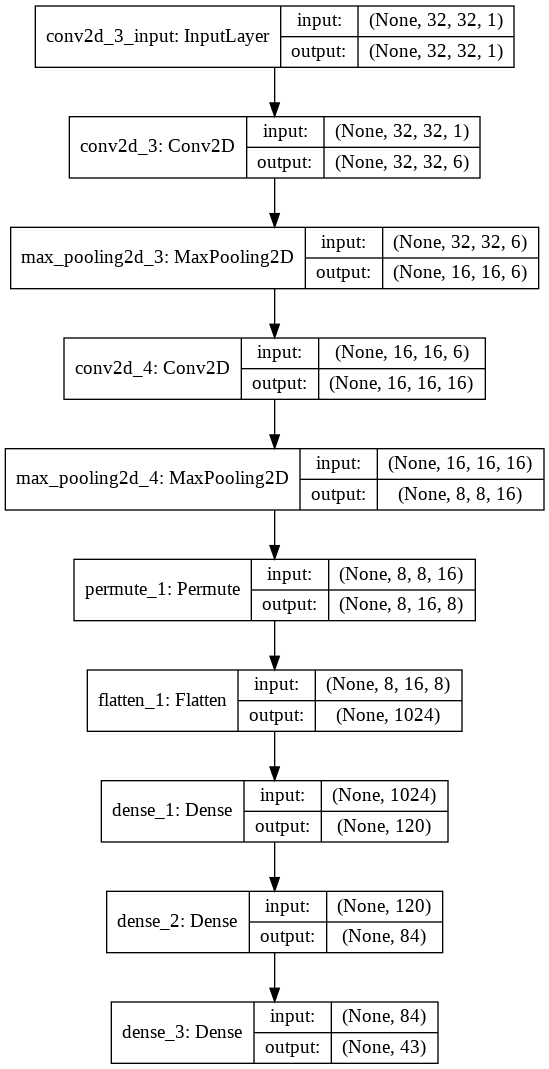

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',expand_nested= True,show_shapes=True)

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [0]:
layer_no = 2 # 2,0
for layer_no in [0,2]:
  kernelWidth = model.layers[layer_no].get_weights()[0].shape[0]
  kernelHeight = model.layers[layer_no].get_weights()[0].shape[1]
  kernelDepth = model.layers[layer_no].get_weights()[0].shape[2]
  print("Kernel Width : ", kernelWidth)
  print("Kernel Height : ", kernelHeight)
  print("Kernel Depth : ", kernelDepth)
  numChannels = model.layers[layer_no].get_weights()[0].shape[3]
  print("Num Channels : ", numChannels)
  fileName = model.layers[layer_no].name
  fileName += ".txt"
  fileHandler = open(fileName, "w")
  for channels in range(0, numChannels):
    for depth in range(kernelDepth):
      for width in range(kernelWidth):
        for height in range(kernelHeight):
          fileHandler.write(str(model.layers[layer_no].get_weights()[0][width, height, depth, channels]) + " ")
  fileHandler.write("\n")
  # Store biases
  for channels in range(0, numChannels):
    fileHandler.write(str(model.layers[layer_no].get_weights()[1][channels]) + " ");
  fileHandler.close()


Kernel Width :  5
Kernel Height :  5
Kernel Depth :  1
Num Channels :  6
Kernel Width :  5
Kernel Height :  5
Kernel Depth :  6
Num Channels :  16


In [0]:
# Fully connected
for fc_layer in [6,7,8]:
  #fc_layer = 7   # 5,6,7
  inputFeatures = model.layers[fc_layer].get_weights()[0].shape[0]
  outFeatures = model.layers[fc_layer].get_weights()[0].shape[1]
  print("Input features dim : ", inputFeatures)
  print("Out Features dim : ", outFeatures)
  fileName = model.layers[fc_layer].name
  fileName += ".txt"
  fileHandler = open(fileName, "w")
  for outFeature in range(0, outFeatures):
    for inFeature in range(0, inputFeatures):
      fileHandler.write(str(model.layers[fc_layer].get_weights()[0][inFeature][outFeature]) + " ")
  fileHandler.write("\n")

  for bias in range(0, outFeatures):
    fileHandler.write(str(model.layers[fc_layer].get_weights()[1][bias]) + " ")
  fileHandler.close()

Input features dim :  1024
Out Features dim :  120
Input features dim :  120
Out Features dim :  84
Input features dim :  84
Out Features dim :  43


In [0]:
# Storing Convolution layer
#for no_layers in [0,2]:
 # print(no_layers)
  #layer_weights_all = model.layers[no_layers].get_weights()[0]
  #layer_biases_all  = model.layers[no_layers].get_weights()[1]
  #print(model.layers[no_layers].name)
  #print(layer_weights_all.shape)
  #file_name = model.layers[no_layers].name + '.txt'
  #f= open(file_name,"w+")
  #for filter_no in range(0,layer_weights_all.shape[3]):
  #  data = layer_weights_all[:,:,:,filter_no].flatten()
  #  for index in range(0,len(data)):
  #    f.write("%f " % (data[index]))
  #f.write("\n")
  #for bias_index in range(0,len(layer_biases_all)):
  #  f.write("%f "% layer_biases_all[bias_index])
  #f.close()
  #print(len(data))
  #a = tuple(first_layer_weights)
  #!echo "$data" >> "$file_name"
  
#print((first_layer_weights))
#print((first_layer_biases))

In [0]:
# Storing FC data
#for no_layers in [5,6,7]:
 # print(no_layers)
  #layer_weights_all = model.layers[no_layers].get_weights()[0]
  #layer_biases_all  = model.layers[no_layers].get_weights()[1]
  #print(model.layers[no_layers].name)
  #print(layer_weights_all.shape)
  
  #file_name = model.layers[no_layers].name + '.txt'
  
  #f= open(file_name,"w+")
  #for row_no in range(0,layer_weights_all.shape[0]):
  #  data = layer_weights_all[row_no,:].flatten()
  #  for index in range(0,len(data)):
  #    f.write("%f " % (data[index]))
  #f.write("\n")
  #for bias_index in range(0,len(layer_biases_all)):
  #  f.write("%f "% layer_biases_all[bias_index])
  #f.close()